In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters_h1h2 as plotters_h1h2
import Learning.training_data as training_data

%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

cuda
{'l1': 3.1, 'l2': 2.0, 'm': 3.0, 'g': 9.81, 'xa': 5.0, 'ya': 1.0}


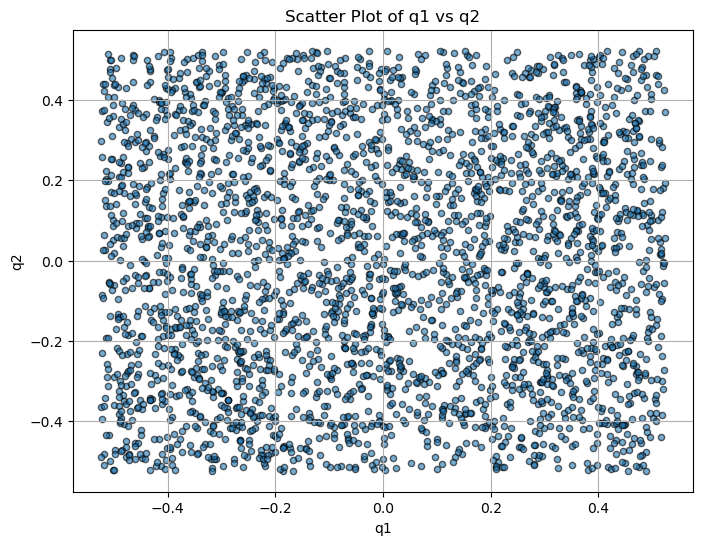

In [3]:
import numpy as np


# Retrieve training points
points = training_data.points.to(device)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Compute mass- and input matrix of all training points to reduce load in training

data_pairs = []
for point in points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    data_pairs.append((point, Mq_point, Aq_point))

points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

# Create TensorDataset
dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
print(len(dataset))


3000


In [5]:
# Split into training and test sets (80% train, 20% test)

batch_size = 512
train_part = 0.7

train_size = int(train_part * len(points))
val_size = len(points) - train_size


# Create TensorDataset for both training and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the DataLoader for both training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


##Iterate through the DataLoader
#for batch in train_dataloader:
    #print(batch[0])
    #break  # Just to show one batch

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2
    
    def theta_ana(self, q):
        theta_1_ana, _ = torch.vmap(self.encoder_theta_1_ana)(q)
        theta_2_ana, _ = torch.vmap(self.encoder_theta_2_ana)(q)
        theta_ana = torch.cat((theta_1_ana, theta_2_ana), dim=1)
        return theta_ana

    def encoder_nn(self, q):
        theta = self.encoder(q)
        return theta, theta
    
    def decoder_nn(self, theta):
        q_hat = self.decoder(theta)
        return q_hat, q_hat
    
    def forward(self, q):
        
        J_h_1_ana, theta_1_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        J_h_ana = torch.cat((J_h_1_ana, J_h_2_ana), dim=1).float()
        
        
        J_h, theta = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)

        J_h_dec, q_hat = torch.vmap(torch.func.jacfwd(self.decoder_nn, has_aux=True))(theta)

        return(theta, J_h, q_hat, J_h_dec, J_h_ana)

In [7]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
save_path = os.path.join(save_directory, file_name)
load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 301

print(save_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / num_epochs))



/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202501041635.pth


CPU times: user 674 ms, sys: 48.2 ms, total: 722 ms
Wall time: 718 ms


In [8]:
import torch.nn.functional as F

def loss_fun(q, q_hat, m_matrix, input_matrix, J_h, J_h_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    #J_h_inv = torch.transpose(J_h, 1, 2)
    J_h_trans = torch.transpose(J_h, 1, 2)
    J_h_inv = J_h_dec
    J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
    
    J_ortho = J_h @ J_h_trans
    J_ortho_inv = J_h_inv @ J_h_inv_trans
    
    identity_matrix = J_h @ J_h_inv  # Batch-wise multiplication
    unitary_target = torch.eye(identity_matrix.size(-1), device=identity_matrix.device).expand(identity_matrix.size(0), -1, -1)
    l_J_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm
    l_J_ortho = 0.01 * torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho)**2)  # Frobenius norm
    l_J_ortho_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho_inv)**2)  # Frobenius norm

    # Diagonal loss
    diag_matrix = J_h_inv_trans @ m_matrix @ J_h_inv  # Batch-wise diagonalization
    l_diag = torch.sum(diag_matrix**2) - torch.sum(torch.diagonal(diag_matrix, dim1=1, dim2=2)**2)  # Penalize off-diagonal terms

    ## input decoupling loss
    input_x = J_h_inv_trans @ input_matrix
    l_input = torch.sum((input_x[:, 1]**2)) + torch.sum(((input_x[:, 0]-1)**2))

    loss = l_recon + l_J_inv + l_diag + l_input + l_J_ortho_inv + l_J_ortho 
    loss_terms = torch.tensor([l_recon, l_J_inv, l_J_ortho, l_J_ortho_inv, l_diag, l_input])

    return loss, loss_terms

In [9]:
import torch.nn.functional as F

def loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec):

    l_h_cheat = F.mse_loss(theta, theta_ana, reduction="sum")
    l_J_cheat = F.mse_loss(J_h, J_h_ana, reduction="sum")
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    identity_matrix = J_h @ J_h_dec  # Batch-wise multiplication
    l_J_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm

    loss = l_h_cheat + l_J_cheat + l_recon + l_J_inv
    loss_terms = torch.tensor([l_h_cheat, l_J_cheat, l_recon, l_J_inv, 0, 0])

    return loss, loss_terms

In [10]:


outputs = []
plt.ion()

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):

    # Training phase
    model.train()
    train_loss = 0
    train_loss_terms = torch.zeros(6)
    for index, (q, M_q, A_q) in enumerate(train_dataloader):
        #batch_size = batch[0].shape[0]
        q = q.to(device)
        #q.requires_grad = True
        #q_d = batch[0].to(device)

        M_q = M_q.to(device)
        A_q = A_q.to(device)
        
        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)  
        theta_ana = model.theta_ana(q)
                
        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_terms += loss_terms
    train_loss /= len(train_dataloader.dataset)
    train_loss_terms /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    val_loss_terms = torch.zeros(6)
    with torch.no_grad():
      for index, (q, M_q, A_q) in enumerate(val_dataloader):
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
        theta_ana = model.theta_ana(q)

        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        val_loss += loss.item()
        val_loss_terms += loss_terms
    val_loss /= len(val_dataloader.dataset)
    val_loss_terms /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    epoch_duration = time.time() - start_time
    scheduler.step()

    if epoch % 10 == 0:
        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds'
            )

        print(
            f"recon: {val_loss_terms[0].item():.4f}, "
            f"J_inv: {val_loss_terms[1].item():.4f}, "
            f"J_ortho: {val_loss_terms[2].item():.4f}, "
            f"J_ortho_inv: {val_loss_terms[3].item():.4f}, "
            f"diag: {val_loss_terms[4].item():.4f}, "
            f"input: {val_loss_terms[5].item():.4f}"
        )
        """
        print(
            f"theta: {val_loss_terms[0].item():.4f}, "
            f"J_h: {val_loss_terms[1].item():.4f}, "
            f"recon: {val_loss_terms[2].item():.4f}, "
            f"J_inv: {val_loss_terms[3].item():.4f}, "
        )"""

Epoch [1/301], Training Loss: 5.2012, Validation Loss: 4.7498, Duration: 0.71 seconds
recon: 0.1965, J_inv: 1.9431, J_ortho: 0.0191, J_ortho_inv: 1.9581, diag: 0.0003, input: 0.6327
Epoch [11/301], Training Loss: 1.7537, Validation Loss: 1.7210, Duration: 4.58 seconds
recon: 0.0173, J_inv: 0.2229, J_ortho: 0.1038, J_ortho_inv: 0.8263, diag: 0.0174, input: 0.5333
Epoch [21/301], Training Loss: 1.6128, Validation Loss: 1.6242, Duration: 8.48 seconds
recon: 0.0196, J_inv: 0.3252, J_ortho: 0.0717, J_ortho_inv: 0.8107, diag: 0.0439, input: 0.3530
Epoch [31/301], Training Loss: 1.5879, Validation Loss: 1.5628, Duration: 12.32 seconds
recon: 0.0159, J_inv: 0.2740, J_ortho: 0.0675, J_ortho_inv: 0.7837, diag: 0.0102, input: 0.4113
Epoch [41/301], Training Loss: 1.5600, Validation Loss: 1.5446, Duration: 16.11 seconds
recon: 0.0169, J_inv: 0.2983, J_ortho: 0.0651, J_ortho_inv: 0.7950, diag: 0.0204, input: 0.3489
Epoch [51/301], Training Loss: 1.5372, Validation Loss: 1.5218, Duration: 20.16 seco

In [11]:
print((J_h @ torch.transpose(J_h, 1, 2))[30:33])

tensor([], device='cuda:0', size=(0, 2, 2))


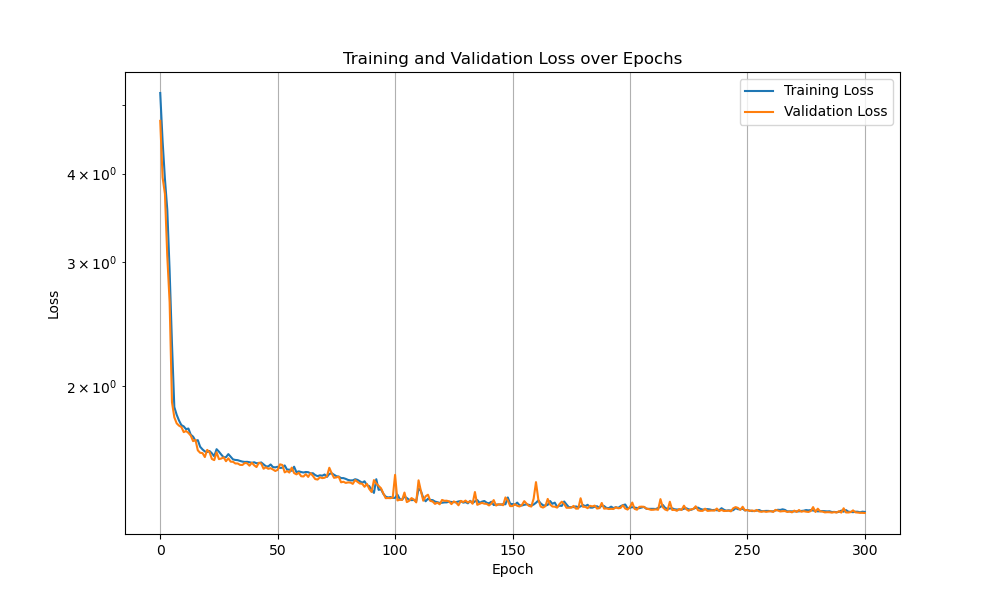

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.grid(True)
plt.yscale("log")
plt.show()


In [13]:
plot_points = plotters_h1h2.plot_data(device)

plot_data_pairs = []
for point in plot_points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    plot_data_pairs.append((point, Mq_point, Aq_point))

plot_points_tensor = torch.stack([pair[0] for pair in plot_data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in plot_data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in plot_data_pairs])  # Tensor of all input matrices

# Create TensorDataset
plot_dataset = TensorDataset(plot_points_tensor, mass_matrices_tensor, input_matrices_tensor)
plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

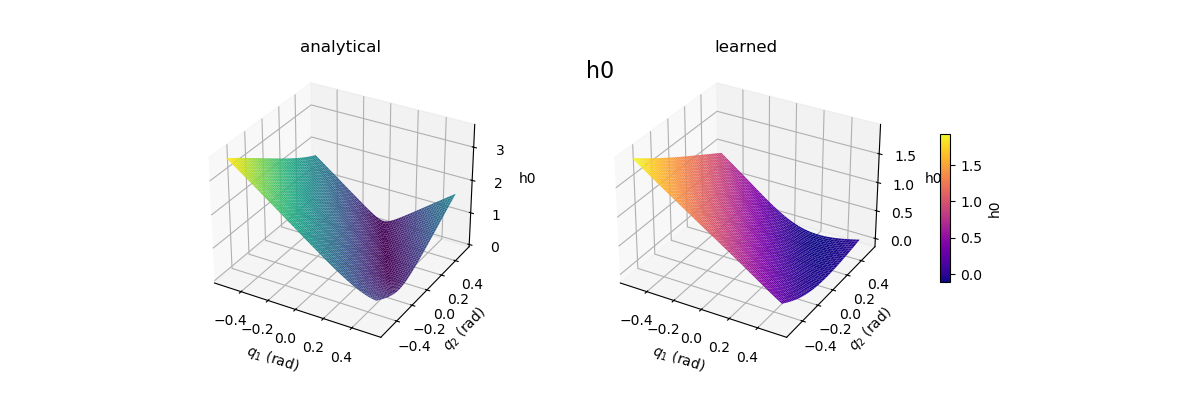

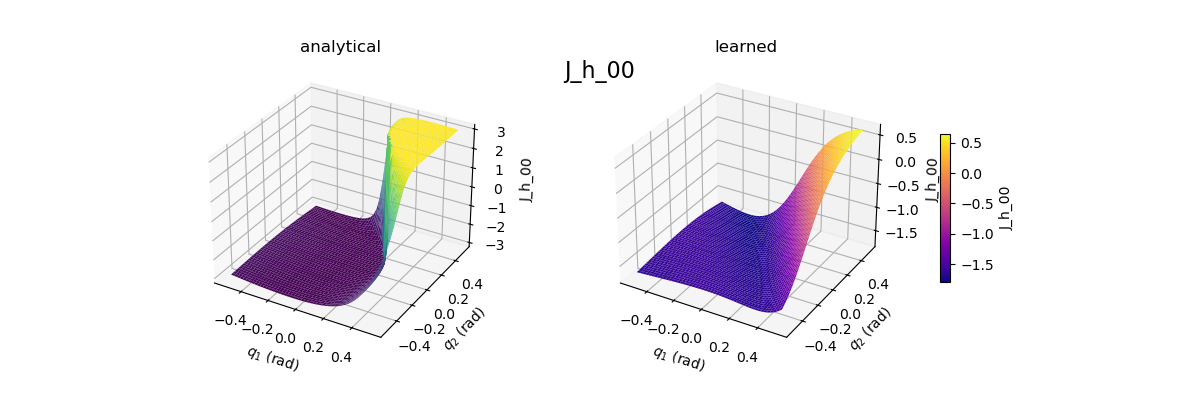

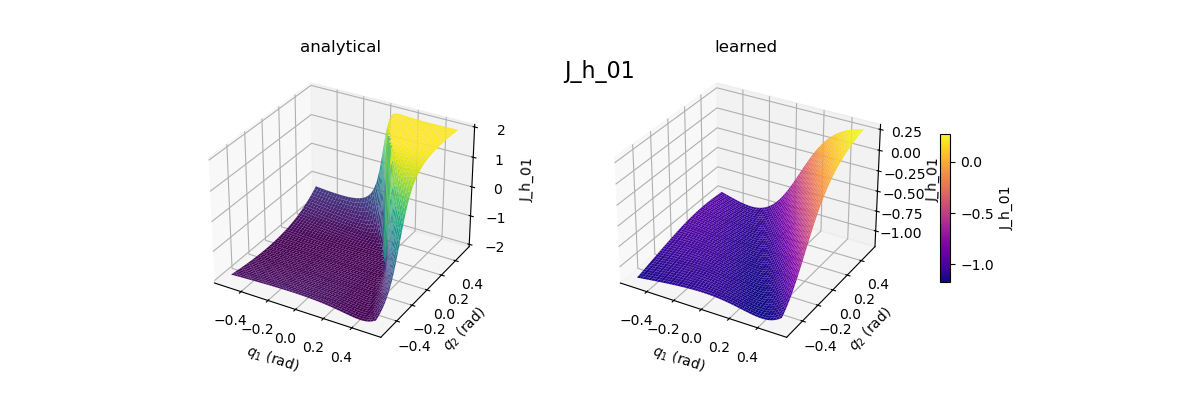

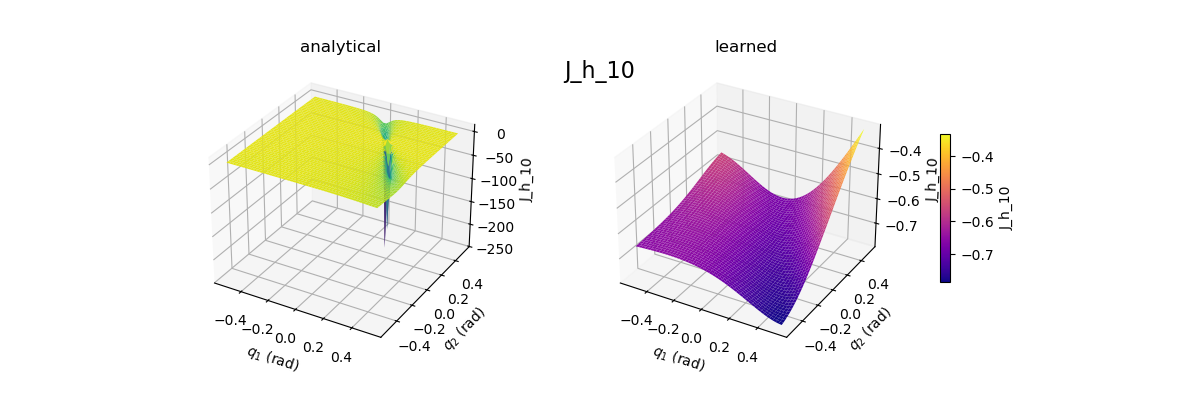

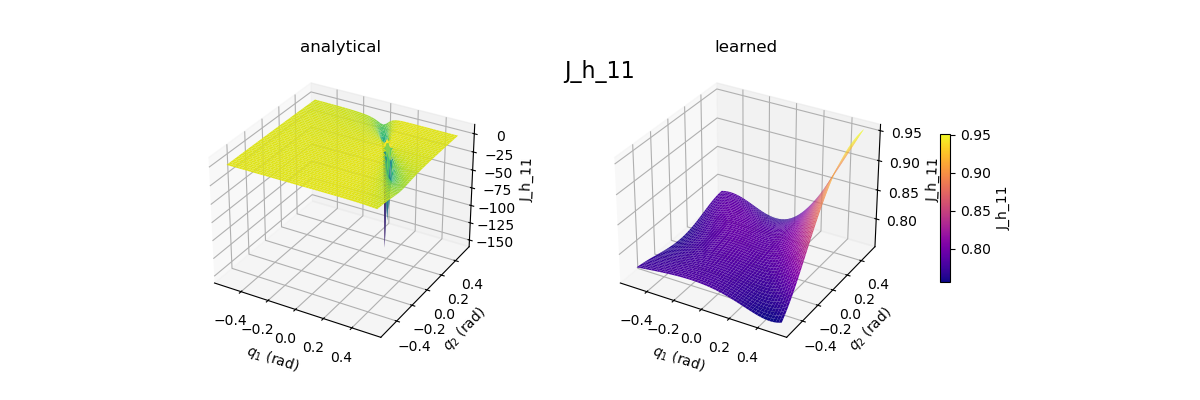

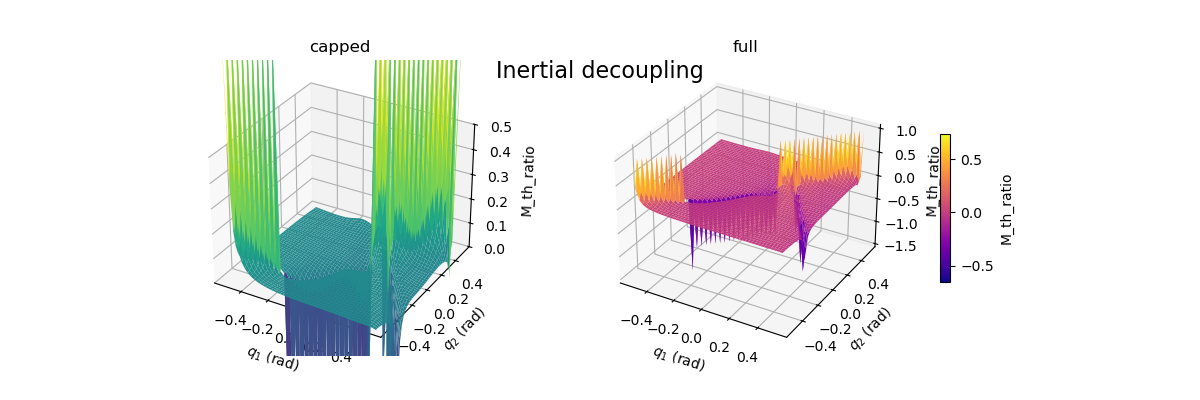

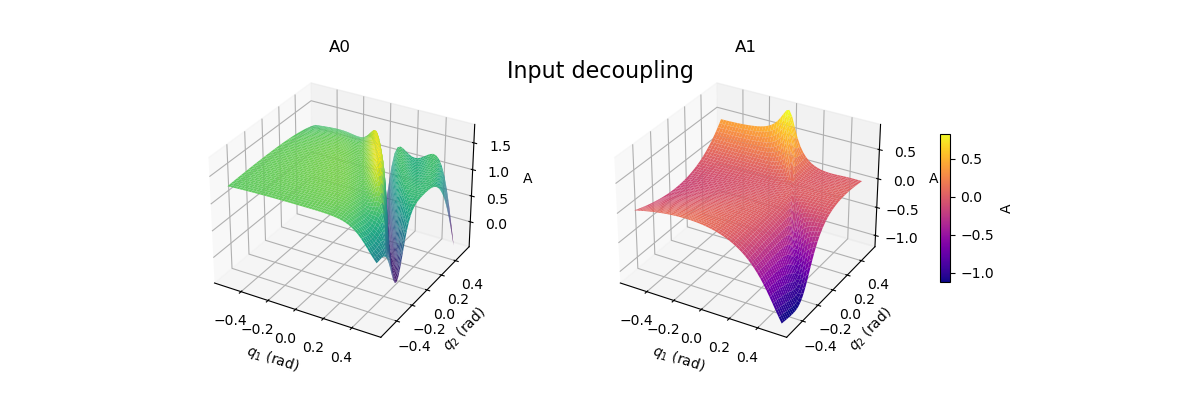

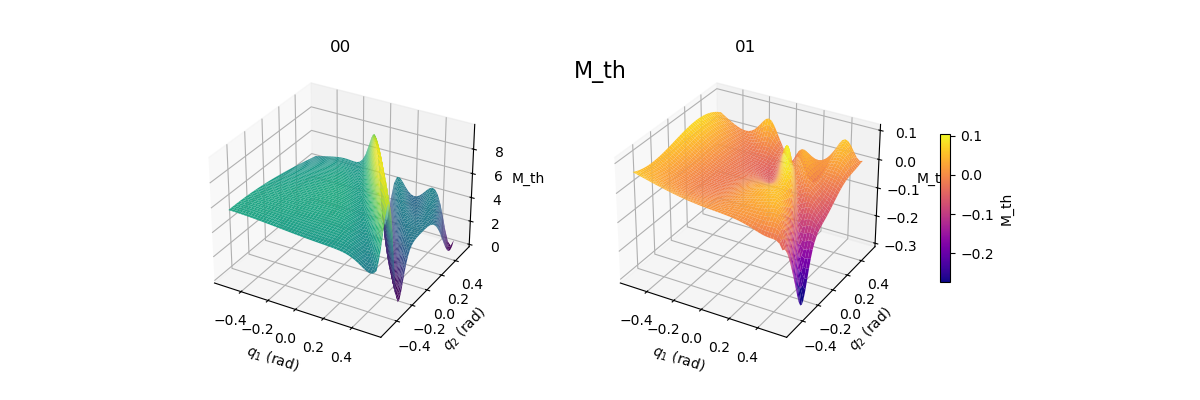

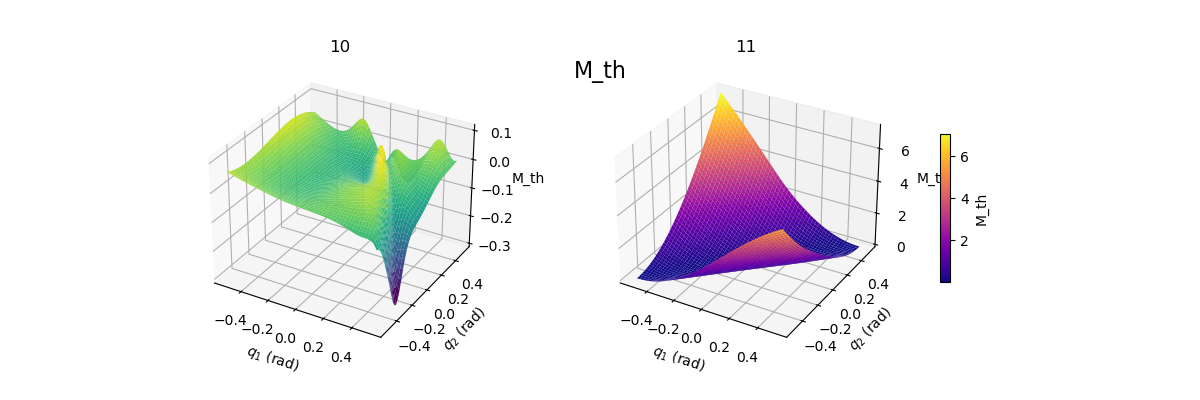

In [14]:
import Plotting.plotters_simple as plotters_simple

model.eval()
with torch.no_grad():
    for (q, M_q, A_q) in plot_dataloader:
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
        theta_ana = model.theta_ana(q)
        J_h_trans = torch.transpose(J_h, 1, 2)
        J_h_inv = J_h_dec
        J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
        M_th = J_h_inv_trans @ M_q @ J_h_inv
        A_th = J_h_inv_trans @ A_q

        off_dia = M_th[:, 0, 1]
        diag_elements = M_th[:, [0, 1], [0, 1]]
        diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1])# + 1e-8
        M_th_ratio = off_dia/diag_product


        J_ortho = J_h @ J_h_trans        
        identity_matrix = J_h @ J_h_inv  # Batch-wise multiplication
        l_J_inv = ((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2).sum(dim=(1,2)) 
        l_J_ortho = ((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho)**2).sum(dim=(1,2))

        
        plotters_simple.plot_3d_double(theta_ana[:, 0], theta[:, 0], "h0", "analytical", "learned", "h0", device)
        plotters_simple.plot_3d_double(theta_ana[:, 1], theta[:, 1], "h1", "analytical", "learned", "h1", device)

        plotters_simple.plot_3d_double(J_h_ana[:, 0, 0], J_h[:, 0, 0], "J_h_00", "analytical", "learned", "J_h_00", device)
        plotters_simple.plot_3d_double(J_h_ana[:, 0, 1], J_h[:, 0, 1], "J_h_01", "analytical", "learned", "J_h_01", device)
        plotters_simple.plot_3d_double(J_h_ana[:, 1, 0], J_h[:, 1, 0], "J_h_10", "analytical", "learned", "J_h_10", device)
        plotters_simple.plot_3d_double(J_h_ana[:, 1, 1], J_h[:, 1, 1], "J_h_11", "analytical", "learned", "J_h_11", device)

        plotters_simple.plot_3d_double(M_th_ratio, M_th_ratio, "Inertial decoupling", "capped", "full", "M_th_ratio", device, z_limits = (0, 0.5))

        plotters_simple.plot_3d_double(A_th[:, 0], A_th[:, 1], "Input decoupling", "A0", "A1", "A", device)

        plotters_simple.plot_3d_double(l_J_ortho, l_J_inv, "Jacobian properties", "Orthogonality J_h", "J_h@J_h_inv - I", "J_h", device)
        
        plotters_simple.plot_3d_double(M_th[:, 0, 0], M_th[:, 0, 1], "M_th", "00", "01", "M_th", device)
        plotters_simple.plot_3d_double(M_th[:, 1, 0], M_th[:, 1, 1], "M_th", "10", "11", "M_th", device)
        

In [15]:
print("J_h:\n", J_h[1400:1402])
print("J_h_dec:\n", J_h_dec[1400:1402])
print("J_h_inv:\n", J_h_inv[1400:1402])
print("J_h@J_h_dec:\n", (J_h@J_h_dec)[1400:1402])

print("J_h@J_h_trans:\n", (J_h@J_h_trans)[1400:1402])
print("J_h_inv@J_h_inv_trans:\n", (J_h_inv@J_h_inv_trans)[1400:1402])


print("M_th:\n", M_th[1400:1402])
print("A_th:\n", A_th[1400:1402])

J_h:
 tensor([[[-1.5989, -1.0950],
         [-0.6841,  0.7776]],

        [[-1.6025, -1.0952],
         [-0.6851,  0.7775]]], device='cuda:0')
J_h_dec:
 tensor([[[-0.2663, -0.5145],
         [-0.2775,  0.8259]],

        [[-0.2667, -0.5159],
         [-0.2775,  0.8261]]], device='cuda:0')
J_h_inv:
 tensor([[[-0.2663, -0.5145],
         [-0.2775,  0.8259]],

        [[-0.2667, -0.5159],
         [-0.2775,  0.8261]]], device='cuda:0')
J_h@J_h_dec:
 tensor([[[ 0.7296, -0.0817],
         [-0.0336,  0.9943]],

        [[ 0.7313, -0.0781],
         [-0.0330,  0.9957]]], device='cuda:0')
J_h@J_h_trans:
 tensor([[[3.7555, 0.2423],
         [0.2423, 1.0728]],

        [[3.7674, 0.2463],
         [0.2463, 1.0739]]], device='cuda:0')
J_h_inv@J_h_inv_trans:
 tensor([[[ 0.3356, -0.3510],
         [-0.3510,  0.7591]],

        [[ 0.3373, -0.3521],
         [-0.3521,  0.7594]]], device='cuda:0')
M_th:
 tensor([[[5.2391, 0.0141],
         [0.0141, 2.7564]],

        [[5.2826, 0.0130],
         [0.0130

In [16]:
print(-1.8490e-02/(np.sqrt(3.3856e+01 * 1.0305e-05)))

-0.989908583624716


tensor([-1.5708, -1.5708, -1.5708,  ...,  1.5708,  1.5708,  1.5708],
       device='cuda:0')


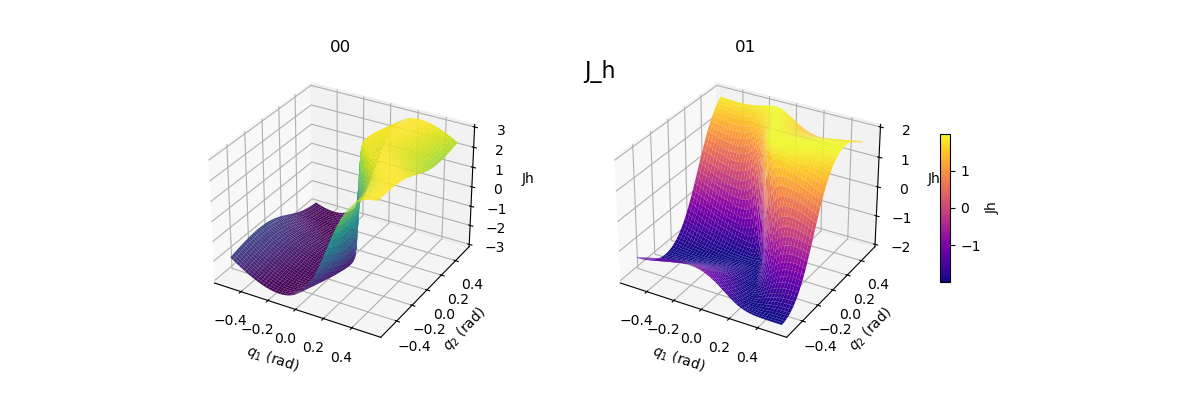

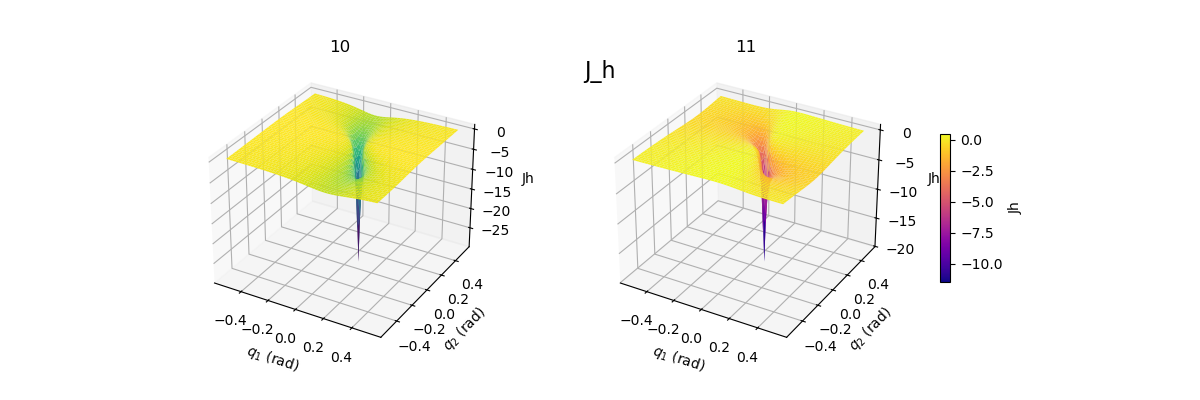

torch.Size([2500])
tensor([-1.9206, -1.8918, -1.8639,  ...,  2.2975,  2.3196,  2.3426],
       device='cuda:0')


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

l1 = 3.
l2 = 2.
m = 3.
g = 9.81
xa = 5.
ya = 1.


q1_plot = torch.linspace(-torch.pi/2, torch.pi/2, 50)
q2_plot = torch.linspace(-torch.pi/2, torch.pi/2, 50)
q1_grid, q2_grid = torch.meshgrid(q1_plot, q2_plot, indexing='ij')
plot_points = torch.stack([q1_grid.flatten(), q2_grid.flatten()], dim=-1).to(device)  # Shape: (N, 2)

print(plot_points[:,0])

q1 = plot_points[:,0]
q2 = plot_points[:,1]

### From Mathematica
J_h_00 = - (l1 * (l2 * torch.sin(q1 - q2) - xa * torch.sin(q1) + ya * torch.cos(q1))
            ) / torch.sqrt((l1 * torch.cos(q1) + l2 * torch.cos(q2) - xa)**2 +
                           (l1 * torch.sin(q1) + l2 * torch.sin(q2) - ya)**2)
J_h_01 = (l2 * (l1 * torch.sin(q1 - q2) + xa * torch.sin(q2) - ya * torch.cos(q2))
            ) / torch.sqrt((l1 * torch.cos(q1) + l2 * torch.cos(q2) - xa)**2 +
                           (l1 * torch.sin(q1) + l2 * torch.sin(q2) - ya)**2)
J_h_10 = (l1*(l1+l2*torch.cos(q1-q2)-xa*torch.cos(q1)-ya*torch.sin(q1))
          ) / (l1**2 + 2 * l1 * l2 * torch.cos(q1-q2) - 2 * l1 * xa * torch.cos(q1)
               - 2 * l1 * ya * torch.sin(q1) + l2**2 - 2 * l2 * xa * torch.cos(q2)
               -2 * l2 * ya * torch.sin(q2) + xa**2 + ya**2)
J_h_11 = (l2*(l2+l1*torch.cos(q1-q2)-xa*torch.cos(q2)-ya*torch.sin(q2))
          ) / (l1**2 + 2 * l1 * l2 * torch.cos(q1-q2) - 2 * l1 * xa * torch.cos(q1)
               - 2 * l1 * ya * torch.sin(q1) + l2**2 - 2 * l2 * xa * torch.cos(q2)
               -2 * l2 * ya * torch.sin(q2) + xa**2 + ya**2)

plotters_simple.plot_3d_double(J_h_00, J_h_01, "J_h", "00", "01", "Jh", device)
plotters_simple.plot_3d_double(J_h_10, J_h_11, "J_h", "10", "11", "Jh", device)

print(J_h_00.size())
print(J_h_00)

